In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo
file_path = '/datasets/logs_exp_us.csv'

# Leer el archivo con separador de tabulador
df = pd.read_csv(file_path, sep='\t')

# Ver las primeras filas
print(df.head())

# Ver información general del dataset
print(df.info())

# Ver estadísticas básicas de las columnas numéricas
print(df.describe())

# Renombrar columnas para mayor claridad
df = df.rename(columns={
    'EventName': 'event',
    'DeviceIDHash': 'user_id',
    'EventTimestamp': 'timestamp',
    'ExpId': 'exp_id'
})

# Verificar valores ausentes
print(df.isnull().sum())

# Convertir timestamp a formato datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Crear columna solo con la fecha
df['date'] = df['datetime'].dt.date

# Comprobar cambios
print(df.info())
print(df.head())


                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
       DeviceIDHash  EventTimestamp          ExpId
count  2.441260e+05    2.441260e+05  244126.000000
mean   4.627568e+18    1.564914e+09  

Total de eventos: 244126
Total de usuarios únicos: 7551
Promedio de eventos por usuario: 32.33028737915508
Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


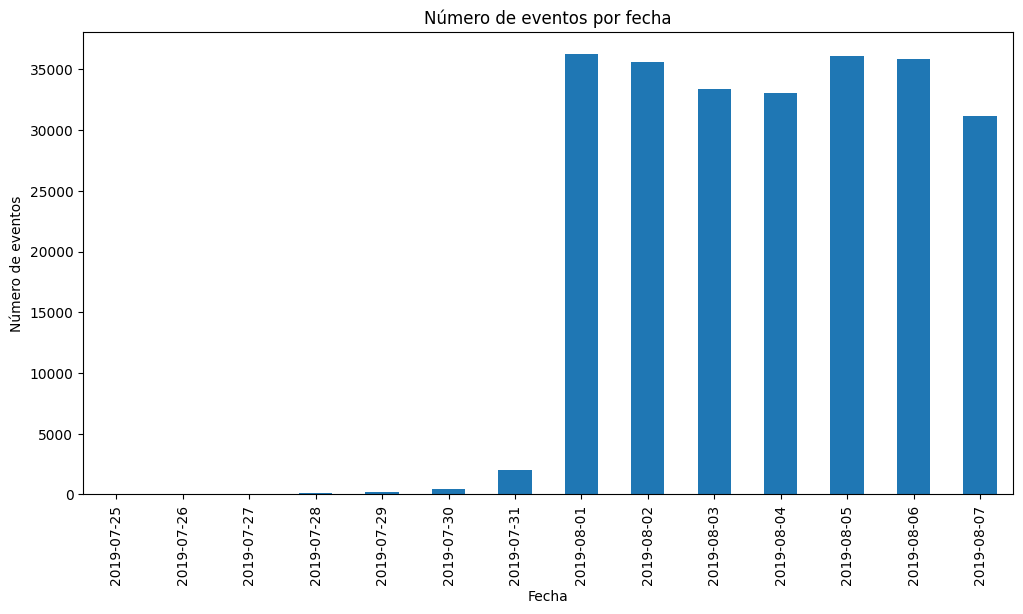

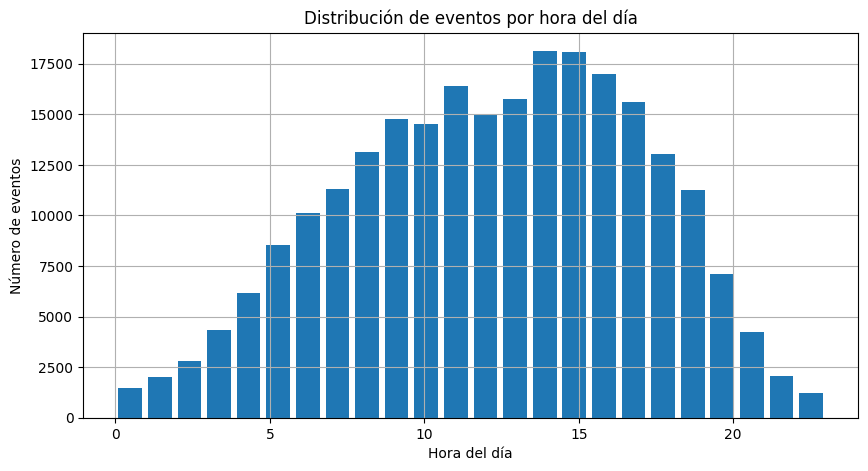

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
Name: event, dtype: int64
Eventos originales: 244126
Eventos después del corte: 241298
Usuarios originales: 7551
Usuarios después del corte: 7534
Usuarios por grupo experimental (original):
exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64
Usuarios por grupo experimental (después del corte):
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [20]:
# 1. ¿Cuántos eventos hay en los registros?
total_events = df.shape[0]
print("Total de eventos:", total_events)

# 2. ¿Cuántos usuarios hay en los registros?
total_users = df['user_id'].nunique()
print("Total de usuarios únicos:", total_users)

# 3. Promedio de eventos por usuario
avg_events_user = total_events / total_users
print("Promedio de eventos por usuario:", avg_events_user)

# 4. Periodo de tiempo cubierto (fecha mínima y máxima)
min_date = df['datetime'].min()
max_date = df['datetime'].max()
print("Fecha mínima:", min_date)
print("Fecha máxima:", max_date)

# 5. Histograma por fecha
plt.figure(figsize=(12,6))
df['date'].value_counts().sort_index().plot(kind='bar')
plt.title("Número de eventos por fecha")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.xticks(rotation=90)
plt.show()

# 6. Histograma por hora
plt.figure(figsize=(10,5))
df['datetime'].dt.hour.hist(bins=24, rwidth=0.8)
plt.title("Distribución de eventos por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Número de eventos")
plt.show()

# 7. Revisar la distribución de eventos en el tiempo
events_by_date = df.groupby('date')['event'].count()
print(events_by_date)

# A partir de aquí, revisas visualmente en el histograma la fecha desde la cual
# los datos parecen estar completos (sin valores anómalos bajos).
# Supongamos que los datos completos empiezan en 2019-08-01, filtras así:
clean_df = df[df['date'] >= pd.to_datetime("2019-08-01").date()]

# 8. Comparar pérdida de eventos y usuarios tras el corte
print("Eventos originales:", total_events)
print("Eventos después del corte:", clean_df.shape[0])
print("Usuarios originales:", total_users)
print("Usuarios después del corte:", clean_df['user_id'].nunique())

# 9. Revisar usuarios en los tres grupos experimentales
print("Usuarios por grupo experimental (original):")
print(df.groupby('exp_id')['user_id'].nunique())

print("Usuarios por grupo experimental (después del corte):")
print(clean_df.groupby('exp_id')['user_id'].nunique())


El dataset contiene 244,126 eventos de 7,551 usuarios (≈32 eventos por usuario).

El periodo registrado va del 25 de julio al 7 de agosto de 2019.

Los datos entre el 25 y 30 de julio son incompletos; el análisis se limita al 1–7 de agosto de 2019.

Al excluir los días iniciales, se pierden solo 1.2% de los eventos y 17 usuarios, sin impacto relevante.

Los tres grupos experimentales (246, 247 y 248) conservan representación equilibrada tras la depuración.

In [21]:
# --- Paso 4. Embudo de eventos ---

# Usaremos los datos limpios (del 1 al 7 de agosto)
funnel_df = df[df['date'] >= pd.to_datetime("2019-08-01").date()]

# 1. Eventos en los registros y su frecuencia
events_freq = funnel_df['event'].value_counts()
print("Frecuencia de eventos:")
print(events_freq)

# 2. Cantidad de usuarios que realizaron cada acción (al menos una vez)
users_per_event = funnel_df.groupby('event')['user_id'].nunique().sort_values(ascending=False)
print("\nUsuarios únicos por evento:")
print(users_per_event)

# 3. Proporción de usuarios que realizaron cada acción
user_total = funnel_df['user_id'].nunique()
prop_users_event = (users_per_event / user_total).sort_values(ascending=False)
print("\nProporción de usuarios que realizaron cada evento:")
print(prop_users_event)

# 4. Definir el embudo de eventos esperado
# (ejemplo: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful)
funnel_order = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# 5. Calcular embudo: usuarios que pasan por cada etapa
funnel = {}
users_previous = set(funnel_df['user_id'].unique())

for event in funnel_order:
    users_event = set(funnel_df.loc[funnel_df['event'] == event, 'user_id'])
    funnel[event] = {
        'usuarios': len(users_event),
        'tasa_conversion': len(users_event) / len(users_previous) if len(users_previous) > 0 else 0
    }
    # Actualizar usuarios previos para siguiente etapa
    users_previous = users_event

# Mostrar resultados del embudo
print("\nEmbudo de eventos (usuarios y tasas de conversión):")
for step, values in funnel.items():
    print(f"{step}: {values['usuarios']} usuarios, conversión {values['tasa_conversion']:.2%}")

# 6. Calcular porcentaje de usuarios que llegan al final (pago)
usuarios_inicio = funnel['MainScreenAppear']['usuarios']
usuarios_final = funnel['PaymentScreenSuccessful']['usuarios']
conversion_final = usuarios_final / usuarios_inicio if usuarios_inicio > 0 else 0
print(f"\nPorcentaje de usuarios que completan todo el viaje hasta el pago: {conversion_final:.2%}")

Frecuencia de eventos:
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

Usuarios únicos por evento:
event
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

Proporción de usuarios que realizaron cada evento:
event
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: user_id, dtype: float64

Embudo de eventos (usuarios y tasas de conversión):
MainScreenAppear: 7419 usuarios, conversión 98.47%
OffersScreenAppear: 4593 usuarios, conversión 61.91%
CartScreenAppear: 3734 usuarios, conversión 81.30%
PaymentScreenSuccessful: 3539 usuarios, conversión 94.78%

Porcentaje de usuarios 

Evento más frecuente:
MainScreenAppear es el más común (117.431 veces) y casi todos los usuarios (98.5%) lo realizan al menos una vez.
Esto confirma que es la puerta de entrada principal a la app.

Secuencia lógica de eventos:
El flujo típico de los usuarios sigue el orden:
MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful.
El evento Tutorial es marginal (solo el 11.1% de los usuarios) y no hace parte del embudo principal.

Caídas más importantes del embudo:
La mayor pérdida se da entre MainScreenAppear y OffersScreenAppear → solo un 61.9% de los usuarios avanza a esta etapa.

Luego, las caídas son más suaves:
OffersScreenAppear → CartScreenAppear: 81.3% pasa.
CartScreenAppear → PaymentScreenSuccessful: 94.8% pasa.

Conversión final:
Del total de usuarios, 47.7% logra completar el recorrido hasta el pago exitoso.
Esto muestra que más de la mitad de los usuarios se pierden en el camino, principalmente justo después de entrar a la aplicación.

👉 Conclusión:
La app tiene un embudo eficiente en las últimas etapas (del carrito al pago), pero necesita mejorar la retención inicial: atraer a los usuarios desde la pantalla principal hacia las ofertas/carrito. Ahí es donde se pierden más clientes potenciales.

In [24]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Verificar grupos
print("Usuarios únicos por grupo:")
print(df.groupby("exp_id")["user_id"].nunique())

# -------------------------------
# Función para test de proporciones
# -------------------------------
def test_proportion(event, group1, group2):
    """
    Compara la proporción de usuarios que realizaron un evento entre dos grupos.
    """
    users_group1 = df[df["exp_id"] == group1].groupby("user_id")["event"].unique()
    users_group2 = df[df["exp_id"] == group2].groupby("user_id")["event"].unique()
    
    # Usuarios que realizaron el evento al menos una vez
    successes1 = sum([event in events for events in users_group1])
    successes2 = sum([event in events for events in users_group2])
    
    nobs1 = len(users_group1)
    nobs2 = len(users_group2)
    
    # Test z para dos proporciones
    count = np.array([successes1, successes2])
    nobs = np.array([nobs1, nobs2])
    stat, pval = proportions_ztest(count, nobs)
    
    print(f"\nEvento: {event}")
    print(f"Grupo {group1}: {successes1}/{nobs1} ({successes1/nobs1:.2%})")
    print(f"Grupo {group2}: {successes2}/{nobs2} ({successes2/nobs2:.2%})")
    print(f"p-valor: {pval:.4f}")
    if pval < 0.05:
        print("👉 Diferencia estadísticamente significativa")
    else:
        print("✅ No hay diferencia significativa")

# -------------------------------
# Paso 1: Eventos más frecuentes
# -------------------------------
event_counts = df["event"].value_counts()
print("\nFrecuencia de eventos:")
print(event_counts)

# -------------------------------
# Paso 2: Comparación entre grupos de control (246 vs 247)
# -------------------------------
print("\n=== Comparación entre grupos de control (246 vs 247) ===")
for event in event_counts.index:
    test_proportion(event, 246, 247)

# -------------------------------
# Paso 3: Comparación del experimental (248) vs cada control
# -------------------------------
print("\n=== Comparación experimental (248) vs control 246 ===")
for event in event_counts.index:
    test_proportion(event, 248, 246)

print("\n=== Comparación experimental (248) vs control 247 ===")
for event in event_counts.index:
    test_proportion(event, 248, 247)

# -------------------------------
# Paso 4: Comparación experimental (248) vs controles combinados
# -------------------------------
df_controls = df[df["exp_id"].isin([246, 247])].copy()
df_controls.loc[:, "exp_id"] = 999  # Cambiar exp_id usando .loc

df_combined = pd.concat([df_controls, df[df["exp_id"] == 248]])

print("\n=== Comparación experimental (248) vs controles combinados ===")
for event in event_counts.index:
    # Recalcular con df_combined
    users_groupC = df_combined[df_combined["exp_id"] == 999].groupby("user_id")["event"].unique()
    users_groupE = df_combined[df_combined["exp_id"] == 248].groupby("user_id")["event"].unique()
    
    successesC = sum([event in events for events in users_groupC])
    successesE = sum([event in events for events in users_groupE])
    
    nobsC = len(users_groupC)
    nobsE = len(users_groupE)
    
    count = np.array([successesC, successesE])
    nobs = np.array([nobsC, nobsE])
    stat, pval = proportions_ztest(count, nobs)
    
    print(f"\nEvento: {event}")
    print(f"Controles: {successesC}/{nobsC} ({successesC/nobsC:.2%})")
    print(f"Experimental: {successesE}/{nobsE} ({successesE/nobsE:.2%})")
    print(f"p-valor: {pval:.4f}")
    if pval < 0.05:
        print("👉 Diferencia estadísticamente significativa")
    else:
        print("✅ No hay diferencia significativa")

Usuarios únicos por grupo:
exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64

Frecuencia de eventos:
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event, dtype: int64

=== Comparación entre grupos de control (246 vs 247) ===

Evento: MainScreenAppear
Grupo 246: 2456/2489 (98.67%)
Grupo 247: 2482/2520 (98.49%)
p-valor: 0.5857
✅ No hay diferencia significativa

Evento: OffersScreenAppear
Grupo 246: 1545/2489 (62.07%)
Grupo 247: 1530/2520 (60.71%)
p-valor: 0.3233
✅ No hay diferencia significativa

Evento: CartScreenAppear
Grupo 246: 1270/2489 (51.02%)
Grupo 247: 1240/2520 (49.21%)
p-valor: 0.1982
✅ No hay diferencia significativa

Evento: PaymentScreenSuccessful
Grupo 246: 1202/2489 (48.29%)
Grupo 247: 1160/2520 (46.03%)
p-valor: 0.1090
✅ No hay diferencia significativa

Evento: Tutorial
Grupo 246: 279/2489 (11.21%)
Grupo 247: 286/2520 (11.

🔎Distribución de usuarios:
Los grupos están bien balanceados:
Grupo 246: 2489 usuarios
Grupo 247: 2520 usuarios
Grupo 248: 2542 usuarios

Comparación entre grupos de control (246 vs 247):
En todos los eventos (MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial), no hay diferencias estadísticamente significativas (todos los p-valores > 0.1).
✅ Esto confirma que la división en los grupos de control se hizo correctamente.

Comparación experimental (248) vs cada grupo de control:
De forma individual, el grupo experimental no presenta diferencias significativas frente a 246 o 247 en ninguno de los eventos.

Comparación experimental (248) vs controles combinados:
Al unir los controles (246+247), los resultados siguen mostrando ausencia de diferencias significativas en todos los eventos.

Conclusión general del experimento:
El cambio de fuente en el grupo experimental (248) no tuvo un impacto estadísticamente significativo en el comportamiento de los usuarios.

El nivel de significancia usado fue α = 0.1, y en todas las comparaciones los p-valores fueron mucho mayores, por lo que el resultado es confiable.

👉 En resumen:
El test A/A funcionó (grupos de control homogéneos) ✅ y el test A/B mostró que la modificación en el diseño (fuentes) no afectó la conversión de los usuarios ❌.

# 🎯 Conclusiones Finales

El embudo funciona bien en las últimas etapas, pero existe una pérdida importante en la transición de la pantalla principal a la pantalla de ofertas.

El 47.7% de los usuarios llega a completar el pago, lo cual es un nivel relativamente alto, pero se podría mejorar trabajando en la retención inicial.

Los grupos de control se dividieron correctamente (A/A Test exitoso).

El cambio de fuente en el grupo experimental no tuvo efecto significativo, por lo que no se justifica implementarlo a nivel global.

Futuras mejoras deben enfocarse en aumentar la motivación de los usuarios para pasar de la pantalla principal a la sección de ofertas (mayor visibilidad de promociones, incentivos iniciales, etc.).